# Deep Learning CA1: CIFAR-10
In this notebook, I will try and develop a deep learning model to classify data points from the CIFAR-10 dataset.

I start by installing a few extra libraries which I will use later on in the notebook. The key library here is Tensorflow Addons, which extends Tensorflow and Keras to include implementations of more advanced deep learning advances.

In [60]:
!pip install -q -U keras-tuner tensorflow_addons

In [61]:
!nvidia-smi

Sun Nov 28 09:46:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |  15503MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [62]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Library Imports
I begin by importanting essential libraries. These are:
- NumPy: use for numerical computations
- Matplotlib: use for plotting
- Pandas: we use this to store our model results
- Plotly: use for plotting
- Tensorflow: Keras with a Tensorflow backend is the primary deep learning library used
- Seaborn: use for plotting

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.datasets.cifar10 import load_data

from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D, Dropout, BatchNormalization, ReLU, Layer, Reshape, Flatten, Activation, Normalization, Multiply, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, TerminateOnNaN, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow_addons.activations import mish
from tensorflow_addons.optimizers import SWA 
from tensorflow_addons.callbacks import AverageModelCheckpoint
# from tensorflow.keras.applications import efficientnet_v2
import keras_tuner as kt
from functools import partial
from tensorflow.image import random_flip_left_right, random_crop, resize_with_crop_or_pad
from tensorflow.keras.models import load_model

## Setting Random Seed
To allow for improved reproducibility, I make sure to set a random seed. 42 is the answer to everything in the universe.

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

## Problem Statement
Our problem statement is to develop a deep learning model that is capable of classifying images from the CIFAR-10 dataset.

### What is [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)?
- CIFAR: Canadian Institute for Advanced Research
- CIFAR-10 is a labelled subset of the 80 million tiny images dataset
- It consists of 60000 32x32 color images in 10 classes
  - They are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- There are 6000 images per class
- CIFAR-10 splits data into 50000 training images, and 10000 test images
- It is a common benchmark dataset, used to evaluate computer vision models

### What are our goals for the model?
Our goals for the model are to develop a model that is able to generalize well to new data points (that is, does not overfit)

The main reason why I'm setting this goal is that while having an accurate model on the training set is nice, if we want to actually use the model in the real world, it ought to be able to generalize well to new data. 
#### Optimizing Metrics (what I want to optimize)
- To ensure that we create a model that generalises well, we want to minimise the difference in accuracy of the model between the training and validation set

#### Satsifying Metrics (what still needs to be satisfied)
- Since the model still needs to be fairly accurate, we expect that the accuracy of the model on the training set must be at least 85% and above, to ensure low avoidable bias.

## Data Ingestion

We will begin by loading our data. Since a function to download the dataset is already included in Keras, we will make use of it to quickly load our data. 

### Data Splits
When training and evaluating our model, we will split our data into a training, validation, and testing set.

The training set will be used to train the model, the validation set for model tuning, and the testing set will be used to evaluate the final model, ensuring that it is able to generalize. (and does not overfit to the validation set as a result of our model tuning)

| Split | Size |
|---|---|
| Training | 40K   |
| Validation | 10K  |
| Testing |  10k   |

In practice, this just means that when training our model, we will use 20% of our training data for validation. We choose a large number of examples for the validation set as we will be making our decisions based on the validation set, so it's important not to overfit to the validation set.

In [65]:
(X_train, y_train), (X_test, y_test) = load_data()
train_size = 40000
X_train, y_train, X_val, y_val = X_train[:train_size], y_train[:train_size], X_train[train_size:], y_train[train_size:]

In [66]:
print("Length of Training Set:", len(X_train))
print("Length of Validation Set:", len(X_val))
print("Length of Testing Set:", len(X_test))

Length of Training Set: 40000
Length of Validation Set: 10000
Length of Testing Set: 10000


Each numbered label in the data set represents a specific article of clothing. To make the labels more readable, we will use a dictionary to map each number to the corresponding description.

In [67]:
class_labels = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck"
}

In [68]:
IMG_SIZE = (32, 32, 3)

## Exploratory Data Analysis
Before we even start modelling, it's important to get a grip on the data. There are a few key questions to ask here:      
- What are the dimensions of each image?
- What do the images look like for each class?
- What is the class distribution? Would accuracy be a useful metric to evaluate the model given the class distribution?
- What is the distribution of the pixels for each color channel?
- What is the "average" image for each class?

In [69]:
X_train[0].shape

(32, 32, 3)

Each image is a RGB 32x32 image. It is important to note that these images are not very large, meaning that the neural network does not need a particularly large receptive field. 

### Vizualising the Dataset

Let's take a look at a subset of random images first.

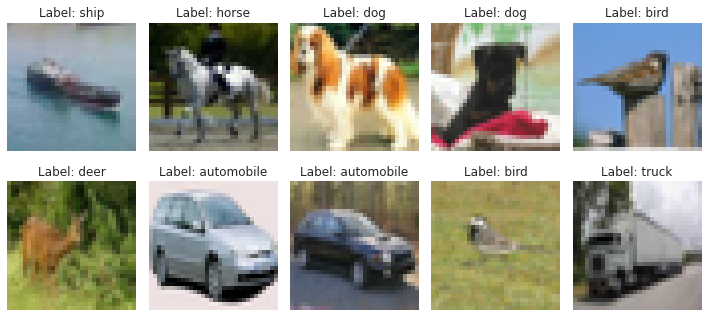

In [70]:
random_idxs = np.random.choice(X_train.shape[0], 10, replace=False)
fig, ax = plt.subplots(2, 5, figsize=(10, 5), tight_layout=True)
for idx, subplot in zip(random_idxs, ax.ravel()):
  subplot.axis("off")
  subplot.imshow(X_train[idx])
  subplot.set_title(f"Label: {class_labels[y_train[idx, 0]]}")

Let's take a look at what each class looks like.

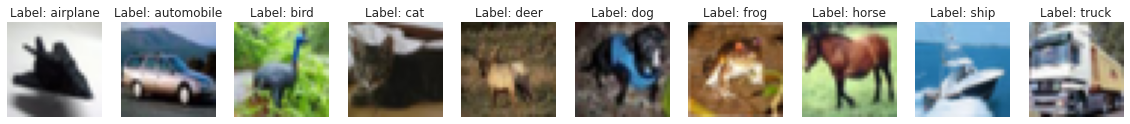

In [71]:
fig, ax = plt.subplots(1, 10, figsize=(20, 15))
for i in range(10):
  images = X_train[np.squeeze(y_train == i)][0]
  label = class_labels[i]
  subplot = ax[i]
  subplot.axis("off")
  subplot.imshow(images)
  subplot.set_title(f"Label: {label}")
fig.show()
    

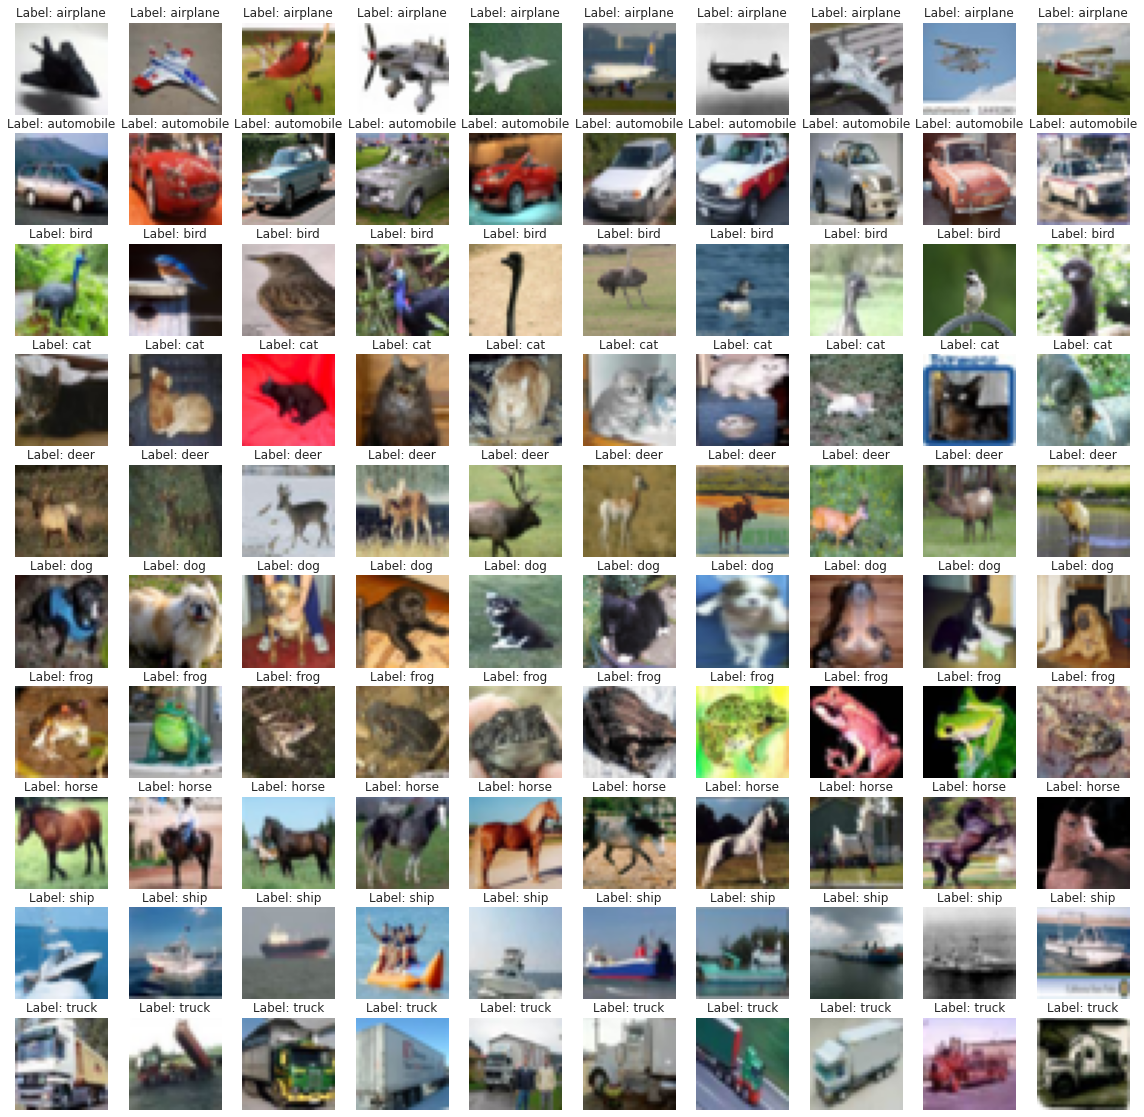

In [72]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
  images = X_train[np.squeeze(y_train == i)][:11]
  label = class_labels[i]
  for j in range(10):
    subplot = ax[i, j]
    subplot.axis("off")
    subplot.imshow(images[j])
    subplot.set_title(f"Label: {label}")
fig.show()
    

We can see that the images are fairly diverse, with different viewing angles. We also note that some of the classes are quite broad. For example, we can see that along with real planes, toy planes are also included in the airplane class.

### Visualization of Class Distribution

In [73]:
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
  print(f"{class_labels[label]}: {count}")

airplane: 3986
automobile: 3986
bird: 4048
cat: 3984
deer: 4003
dog: 3975
frog: 4020
horse: 4023
ship: 3997
truck: 3978


<BarContainer object of 10 artists>

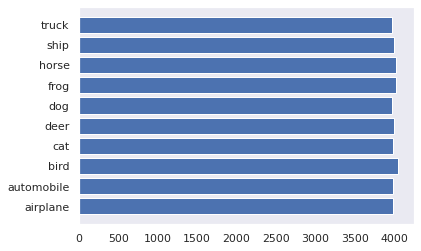

In [74]:
plt.barh(labels, counts, tick_label=list(class_labels.values()))

We can see that there is an even class balance. This means that we can make use of accuracy as our primary metric, as there is no real "minority" class, so accuracy is a good measure of classification performance.

### What does the distribution  of the images look like?

In [75]:
mean, std = np.mean(X_train, axis=(0, 1, 2)), np.std(X_train, axis=(0, 1, 2))
print("Mean:", mean)
print("std:", std)

Mean: [125.32067661 122.92584397 113.78740571]
std: [63.02791301 62.14517894 66.73149283]


These are the average and standard deviation of pixel intensities on each color channel (Red, Blue, Green)
- They are roughly similar

### What is the "average" image?

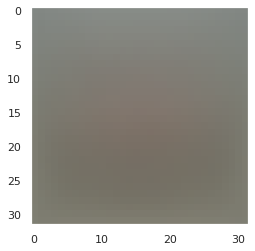

In [76]:
plt.imshow(np.mean(X_train, axis=0) / 255)

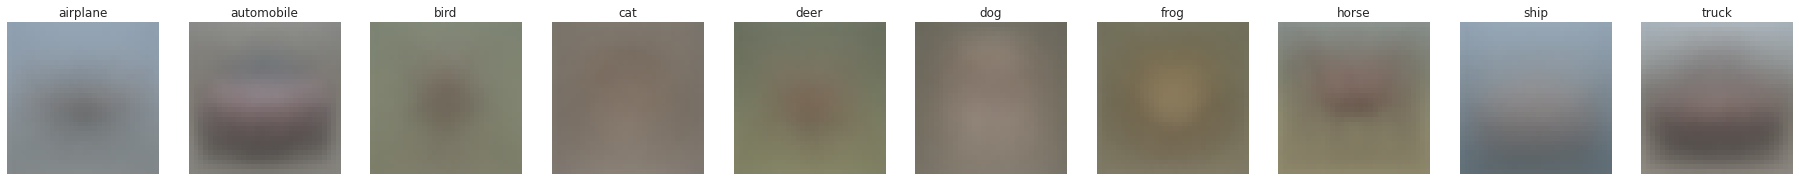

In [77]:
fig, ax = plt.subplots(1, 10, figsize=(32, 10))

for idx, subplot in enumerate(ax):
  avg_image = np.mean(X_train[np.squeeze(y_train == idx)], axis=0) / 255
  subplot.imshow(avg_image)
  subplot.set_title(f"{class_labels[idx]}")
  subplot.axis("off")

Although the average image is fairly blurry, we can still roughly make out the image for the automobile, horse and truck. It is more difficult to make out the average image for the other classes, and could suggest that these classes may be more difficult to predict.

## Basic Data Preprocessing
Before we model the data, it is important to do some basic pre-processing on it. 

### Encoding the Target Labels
As they are, the current labels are in a label encoded format. We will one hot encode the labels by using the `to_categorical` function from the Keras utilities.

In [78]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [79]:
print(y_train[0])
print("Label:", tf.argmax(y_train[0]))

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Label: tf.Tensor(6, shape=(), dtype=int64)


From the one hot encoded label, we can use `argmax` to get back the original label in label encoded form.

### Scaling and Normalizing the Inputs

From prior experimentation, I have found that normalizing the inputs helps in improves the accuracy of the resulting model as it converges faster. This is because the optimization algorithm we will be using, SGD, converges better when the feature scale is approximately the same.

Since we are normalizing the data, the resulting data will be centered around 0 with a standard deviation of 1, and thus we don't need to rescale the image beforehand.

Normalizing the inputs means that we will calculate the mean and standard deviation of the training set, and then apply the formula below

$$
X_{channel} = \frac{X_{channel} - μ_{channel}}{σ_{channel}}
$$

Note that we prevent data leakage by ensuring we don't use any of the validation/testing data to calculate the per-channel mean and std. This is why we did our split into train-val-test beforehand.

In [80]:
BATCH_SIZE = 128 #@param {type:"number"}
pre_processing_v1 = Normalization()
pre_processing_v1.adapt(X_train) # Calculate the mean and std of the train set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


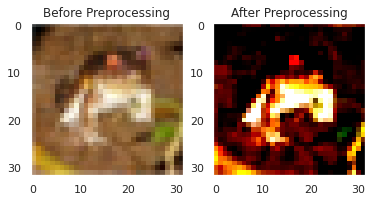

In [81]:
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(X_train[0])
ax[0].set_title('Before Preprocessing')
ax[1].imshow(tf.squeeze(pre_processing_v1(X_train[:1, :, :])))
ax[1].set_title('After Preprocessing')
fig.show()

This is what an image looks like after it has been normalized.

### Basic Data Aug
Since our goal is to prevent overfitting, we also apply data augmentation. Data augmentation is a method to reduce the variance of a model by providing it with more training data. This is done here via doing random flips and crops to an image, to create variations on that image.

- Random Flip: by flipping an image horizontally, we can create an entirely new image
- Random Crop (with padding to retain same image size): acts as a form of random translation, simulating focusing in o different parts of the image.

I picked these simple augmentations for the following reasons:
- I did not want to have too strong of a data augmentation to start with, out of fear that it might cause the model to overfit
- this simple data augmentation has been shown to be decently effective. It was the augmentation method used for well known papers like [Deep Residual Learning for Image Recognition (ResNet)](https://arxiv.org/pdf/1512.03385.pdf), and so I feel quite confident in using this simple data augmentation 

Nevertheless, I will try out a stronger data augmentation method later on as part of my experimentation.

In [82]:
def basic_data_aug(images):
 image = random_flip_left_right(images) 
 image = resize_with_crop_or_pad(image, IMG_SIZE[0] + 4, IMG_SIZE[1] + 4)
 image = random_crop(
     image, size=IMG_SIZE
 )
 return image

In [83]:
def set_up_data_aug(aug_func=basic_data_aug):
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  train_ds = train_ds.map(
      lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE
  ).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return train_ds, val_ds

In [84]:
train_aug_ds, val_ds = set_up_data_aug()

In [85]:
train_ds, val_ds = set_up_data_aug(lambda x : x) # apply no data aug

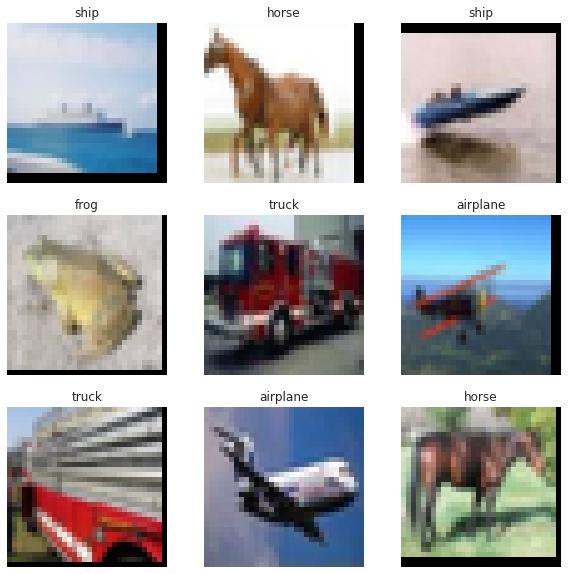

In [86]:
image_batch, label_batch = next(iter(train_aug_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_labels[np.argmax(label_batch[i])])
    plt.imshow(tf.squeeze(image_batch[i]))
    plt.axis("off")

## Modelling
Once we've set up a pre-processing pipeline, we will begin training various models.


### Optimization Algorithm
For all models, we will train them using stochastic gradient descent. This choice was made as SGD seems to generalize better on tasks like image classification, as compared to other optimizers like Adam. Since our primary focus is on building a robust model, it makes sense to use the SGD optimizer. More specifically, we will use SGD with Momentum.

In addition, I will make use of the Cosine Learning Rate Scheduler with Restarts which comes from the [SGD with Warm Restarts](https://arxiv.org/abs/1608.03983) paper. A learning rate scheduler decides how the learning rate should be adjusted during training.

This scheduler works by using a cosine wave to adjust the learning rate, and increasing the learning rate after one cycle, to simulate a restart of the training. This has a few advantages, the warm restart allows the model to escape bad local minima (the increased learning rate during a warm restart let's the model "jump" out of a bad minima and find a better one), and in the [Snapshot Emsembling](https://openreview.net/pdf?id=BJYwwY9ll) paper, it was shown that a copy of the model could be saved before each warm restart to cheaply ensemble together models (train 1, get M for free)
### Choice of Hyperparameters
- Initial Learning Rate: We choose 0.05 as it was the learning rate found to be the best for the Wide Resnet architecture, which we will use later on. 
- Momentum: 0.9 was chosen as momentum generally depends on the batch size, and 0.9 has generally been used for the batch size of 128 that is used. 
- Batch Size
  - Although a smaller batch size has a regularizing effect on the network due to noisier gradient updates, it also makes the overall training process slower
  - In [Measuring the Effects of Data Parallelism
  on Neural Network Training
  ](https://arxiv.org/pdf/1811.03600.pdf), it was found that any potential generalization loss from larger batch sizes can be eliminated through regularization techniques
  - Nevertheless, I choose to be more conservative with my batch size due to worries about limited GPU memory
- Weight Decay: we will regularize our networks with L2 regularization. The weight decay is the same as that used in the Wide ResNet paper. 

### Training
Since each warm restart might cause a temporary degradation in performance, I increase the patience of my Early Stopping to give the model a better chance to recover. 

### Experiment Logger
To make the process of model training more standardized, I have created a class which will keep track of the various Models tested during the notebook.

In [87]:
#@title Base Hyperparameters
LR = 0.05 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
WEIGHT_DECAY = 0.0005 #@param {type:"number"}
MAX_EPOCHS = 200 #@param {type:"integer"}
VAL_SPLIT = 0.2
base_hparams = {
    "val_split" : VAL_SPLIT,
    "max_epochs" : MAX_EPOCHS,
    "batch_size" : BATCH_SIZE
}
from math import ceil
steps_per_epoch = ceil(len(X_train)/ BATCH_SIZE)
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

I create a simple utility function to plot the loss and accuracy of the model as it trains.

In [88]:
def plot_loss_curve(model_history):
  model_history = pd.DataFrame(model_history)
  epochs = list(range(1, len(model_history) + 1))
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=epochs, y=model_history["loss"],
                    mode='lines+markers',
                    name='Training Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_loss"],
                    mode='lines+markers',
                    name='Validation Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["accuracy"],
                    mode="lines+markers",
                    name="Training Accuracy"))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_accuracy"],
                           mode="lines+markers",
                           name="Validation Accuracy"))
  fig.update_layout(
    title="Loss/Acc Plot",
    xaxis_title="Epochs",
    yaxis_title="Loss/Acc",
)

  return fig

To evaluate my model, I created a ModelEvaluator class to keep track of the different experiments conducted and save them offline. My doing this, it means that I can easily record my progress.

In [89]:
class ModelEvaluator:
  """
  A class to keep track of experiments made, so that it is easier to keep track of experimentation
  """
  def __init__(self, history_path = None, base_savedir = "/content/drive/MyDrive/Data/DELE CA1/CIFAR10"):
    if history_path is None:
      self.result_history = pd.DataFrame({
          "Model Name" : [],
          "Epochs" : [],
          "Batch Size" : [],
          "Train Loss" : [],
          "Test Loss" : [],
          "Train Acc" : [],
          "Test Acc" : [],
          "Remarks" : [],
          "Model Path" : []
      })
    else:
      self.result_history = pd.read_csv(history_path, sep=";")
    self.default_callbacks = [
                                  TerminateOnNaN(),
                                  CSVLogger("/tmp/training.log", append=False)
    ]
    self.base_savedir = base_savedir
  def evaluate_model(self, model, training_data = train_ds, validation_data = val_ds, hyperparameters =base_hparams, callbacks = None, plot_loss = True, remarks = "", savedir = None):
    """
    Evaluate a model. Assumes the model has already been compiled, so compilation and choice of optimizer must be done beforehand
    """
    # Train Model
    if callbacks is None:
      callbacks = [EarlyStopping(monitor='val_accuracy',patience=20, restore_best_weights=True)]
    callbacks = self.default_callbacks + callbacks
    name = model.name
    validation_split = hyperparameters["val_split"]
    epochs = hyperparameters["max_epochs"]
    batch_size = hyperparameters["batch_size"]
    if savedir is None:
      filepath = f"{self.base_savedir}/SavedModels/{name}"
    else:
      filepath = savedir
    print(f"Training {name}")
    try:
      if validation_data is None:
        X_train, y_train = training_data
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,callbacks=callbacks)
      else:
        history = model.fit(training_data, validation_data=validation_data, epochs=epochs, batch_size=batch_size,callbacks=callbacks)
      history = history.history
      # print(history)
    except KeyboardInterrupt:
      history = pd.read_csv("/tmp/training.log")
      # print(history)
      print("\nHalting Training")
    print(f"Saving best model to {filepath}")
    if plot_loss:
      try:
        fig = plot_loss_curve(history)
      except:
        print("error creating loss curve")
        fig = None
    else:
      fig = None
    result = dict()
    result["Epochs"] = len(history["loss"])
    result["Batch Size"] = batch_size
    result["Model Name"] = name
    result["Remarks"] = remarks
    result["Model Path"] = filepath
    # Calculate Statistics
    best_val_idx = np.argmax(history["val_accuracy"])
    result["Train Loss"] = history["loss"][best_val_idx]
    result["Test Loss"] = history["val_loss"][best_val_idx]
    result["Train Acc"] = history["accuracy"][best_val_idx]
    result["Test Acc"] = history["val_accuracy"][best_val_idx]
    result["[Train - Test] Acc"] = result["Train Acc"] - result["Test Acc"]
    self.result_history = self.result_history.append(result, ignore_index=True)
    tf.keras.backend.clear_session() # clear all previous models from memory
    return pd.Series(result), fig
  def return_model(self, model_name):
    filepath = self.result_history[
                                   self.result_history["Model Name"] == model_name
    ]["Model Path"]
    assert len(filepath) == 1, "There is no model or more than one model with that name!"
    filepath = filepath.values[0]
    model = tf.keras.models.load_model(filepath)
    return model

  def return_history(self, include_cols = ['Model Name', 'Train Acc', 'Test Acc', '[Train - Test] Acc', 'Remarks'] ):
    return self.result_history[include_cols]

  # def return_training_logs(self, model_name):
  #   raise NotImplementedError

  # def return_loss_plot(self, model_name):
  #   raise NotImplementedError
  #   logs = return_training_logs(model_name)
  #   return plot_loss_curve(logs)
  def remove_model(self, model_name):
    mask = ~(self.result_history["Model Name"] == model_name)
    self.result_history = self.result_history[mask]
  def add_remarks(self, model_name, comment):
    """
    Add comments to a model result
    Comments can include:
      - Sources of Error
      - Notes about model architecture
    """
    mask = (self.result_history["Model Name"] == model_name)
    assert mask.sum() == 1, "There is no model or more than one model with that name!"
    self.result_history.loc[mask, "Remarks"] = comment

  def save_history(self, file_name = None):
    if file_name is None:
      file_name = f"{self.base_savedir}/history.csv"
    self.result_history.to_csv(file_name, sep=";", index=False)
    print(f"History saved to {file_name}")

In [90]:
evaluator = ModelEvaluator("/content/drive/MyDrive/Data/DELE CA1/CIFAR10/history.csv")
# evaluator = ModelEvaluator()

In [91]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Baseline_MLP,0.631750,0.5247,0.107050,High Variance
1,Baseline_CNN_1,0.999825,0.8665,0.133325,Low Avoidable Bias but Overfits
2,Baseline_CNN_1_DataAug,0.996625,0.8826,0.114025,"Data Aug lowers variance, but still overfits"
3,efficientnetv2-s,0.320450,0.3495,-0.029050,NaN
4,ImprovedWideResNet_28_10_No_Stochastic_Depth_B...,0.997800,0.8739,0.123900,NaN
5,ImprovedWideResNet_28_10_No_Stochastic_Depth_B...,0.999425,0.9398,0.059625,NaN
6,ImprovedWideResNet_28_10_ProperDropout_No_Stoc...,0.998900,0.9456,0.053300,Best model thus far
7,ImprovedWideResNet_28_10_Dropout_No_Stochastic...,0.999850,0.9170,0.082850,NaN
8,WideResNet_28_10_Fixed_BasicDataAug,0.998625,0.9333,0.065325,NaN
9,WideResNet_28_10_Fixed_CutMix,0.916025,0.9391,-0.023075,NaN


In [92]:
assert 1 == 2, "Stop Execution Beyond This Point"

AssertionError: ignored

### Baseline: Fully Connected Neural Network
As a simple baseline, I build a fully connected neural network. 

In [ ]:
def build_mlp_network(optimizer):
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs)
  x = Flatten()(x)
  x = Dense(128, 'relu')(x) # Hidden Layer
  x = Dense(128, 'relu')(x)
  x = Dense(128, 'relu')(x)
  x = Dense(10, 'softmax')(x)
  model = Model(inputs=inputs, outputs=x, name='Baseline_MLP')
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
model = build_mlp_network(optimizer)

Model: "Baseline_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 3)         7         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [ ]:
results, fig = evaluator.evaluate_model(model)

Training Baseline_MLP
Epoch 1/200
313/313 [==============================] - 2s 4ms/step - loss: 1.7810 - accuracy: 0.3686 - val_loss: 1.6387 - val_accuracy: 0.4209
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_MLP/assets
Epoch 2/200
313/313 [==============================] - 1s 4ms/step - loss: 1.5824 - accuracy: 0.4370 - val_loss: 1.5925 - val_accuracy: 0.4474
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_MLP/assets
Epoch 3/200
313/313 [==============================] - 1s 4ms/step - loss: 1.4731 - accuracy: 0.4768 - val_loss: 1.5149 - val_accuracy: 0.4676
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_MLP/assets
Epoch 4/200
313/313 [==============================] - 1s 4ms/step - loss: 1.3658 - accuracy: 0.5118 - val_loss: 1.4915 - val_accuracy: 0.4809
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA

In [ ]:
display(results)
fig.show()

Epochs                                                               27
Batch Size                                                          128
Model Name                                                 Baseline_MLP
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/CIFAR10/S...
Train Loss                                                      1.02592
Test Loss                                                       1.42272
Train Acc                                                       0.63175
Test Acc                                                         0.5247
[Train - Test] Acc                                              0.10705
dtype: object

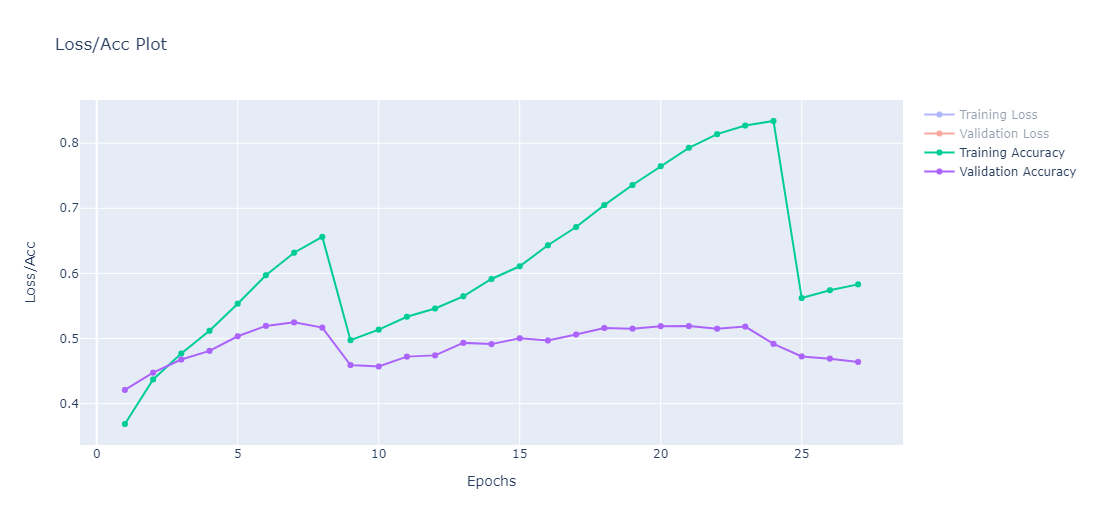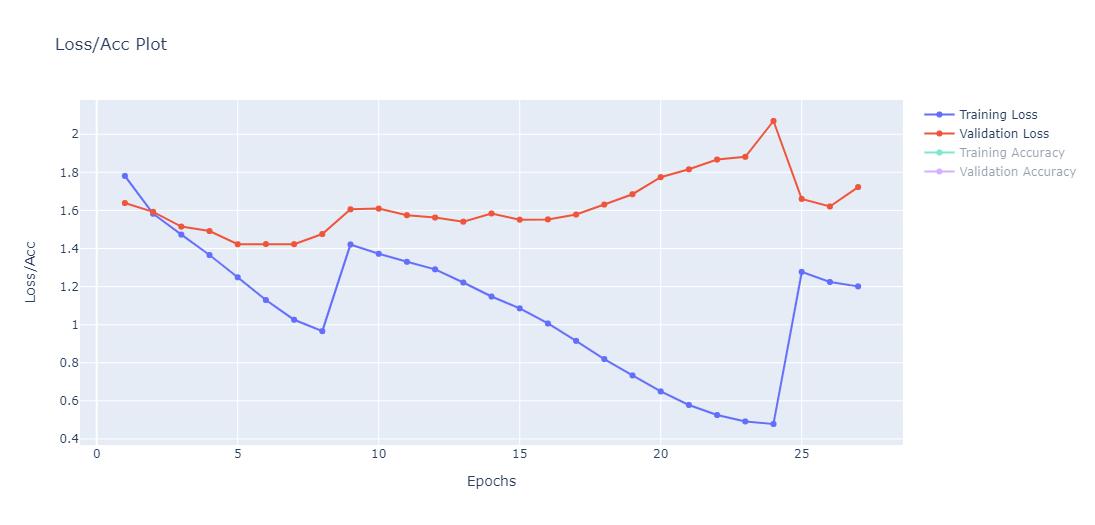

We can see that the overall performance of the model is poor, as the validation and training accuracy is poor.

In [ ]:
evaluator.add_remarks("Baseline_MLP", "High Variance")

To do better, I decide to move towards a CNN architecture. The main reason why I want to move towards a CNN architecture is because CNNs are well suited to the problem of image classification
- They are parameter efficient due to the sparse connections and weight sharing

### Custom VGGNet Inspired Network (10 Conv)
To begin with, we will construct a simple CNN, loosely based off [VGGNet](https://arxiv.org/abs/1409.1556).

Instead of just wholesale taking the VGG architecture, I downsize it and make certain improvements. The reason I do so is 
- VGG architecture is rather old at this point, so I want to bring forward some improvements from other architecture, without making the network too complex
- VGG architecture has a lot of parameters (>100 million parameters), which I think I overkill for this particular problem

So, here's what I've done:
- I reduce the number of convolutional layers to 10. 
- Added Batch Normalization: BN has a regularizing effect on a CNN, by normalising inputs to layers deeper into a network)
- Number of Filters: the number of filters in each layer has been cut in half, to reduce the parameter count
- Global Pooling: While VGGNet flattened their output, global pooling is used instead of flattening the output, which helps to prevent overfitting. This change is taken from Network in Network.
- Dropout: Since I want to reduce overfitting, I add a dropout layer before the final clasification head
- L2 Regularization: To further reduce overfitting.

The end result is a much smaller network than the original VGG networks

My implementation is forked from that given in [Dive into Deep Learning](https://d2l.ai/chapter_convolutional-modern/vgg.html#)

In [ ]:
class BasicConvLayer(Model):
  """
  Basic Conv Layer, with Batch Normalization done before activation
  """
  def __init__(self, filters , activation = ReLU):
    super(BasicConvLayer, self).__init__() # subclassing a layer
    self.layer_conv_1 = Conv2D(filters, (3, 3), padding='same', strides=1, kernel_regularizer=l2(WEIGHT_DECAY))
    self.layer_bn_1 = BatchNormalization()
    self.layer_activation_1 = activation()

  def call(self, X):
    X = self.layer_conv_1(X)
    X = self.layer_bn_1(X)
    return self.layer_activation_1(X)

In [ ]:
class BasicConvBlock(Layer):
  def __init__(self, no_layers, filters, activation=ReLU):
    super(BasicConvBlock, self).__init__()
    self.conv_block = Sequential()
    for _ in range(no_layers):
      self.conv_block.add(
          BasicConvLayer(filters, activation=activation)
      )
    self.conv_block.add(MaxPool2D(strides=2))

  def call(self, X):
    return self.conv_block(X)

In [ ]:
def build_baseline_cnn(optimizer, loss='categorical_crossentropy', name='Baseline_CNN_1'):
  """
  A modified and cut down version of VGG16, using GlobalPooling, and a modified VGGBlock
  """
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs)
  x = BasicConvBlock(2, 32)(x)
  x = BasicConvBlock(2, 64)(x)
  x = BasicConvBlock(3, 128)(x)
  x = BasicConvBlock(3, 256)(x)
  # Global Pooling
  x = GlobalAveragePooling2D()(x) 
  # Classification Head
  x = Dense(128, activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))(x)
  x = Dropout(0.3)(x)
  x = Dense(10, 'softmax', kernel_regularizer=l2(WEIGHT_DECAY))(x)
  model = Model(inputs=inputs, outputs=x, name=name)
  model.compile(optimizer=optimizer,loss=loss, metrics=['accuracy'])
  print(model.summary())
  return model

#### Without Data Augmentation

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
model = build_baseline_cnn(optimizer)

Model: "Baseline_CNN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 3)         7         
_________________________________________________________________
basic_conv_block (BasicConvB (None, 16, 16, 32)        10400     
_________________________________________________________________
basic_conv_block_1 (BasicCon (None, 8, 8, 64)          55936     
_________________________________________________________________
basic_conv_block_2 (BasicCon (None, 4, 4, 128)         370560    
_________________________________________________________________
basic_conv_block_3 (BasicCon (None, 2, 2, 256)         1478400   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)            

In [ ]:
results, fig = evaluator.evaluate_model(model)

Training Baseline_CNN_1
Epoch 1/200
313/313 [==============================] - 20s 13ms/step - loss: 2.2388 - accuracy: 0.4223 - val_loss: 2.0846 - val_accuracy: 0.4518
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_CNN_1/assets
Epoch 2/200
313/313 [==============================] - 4s 11ms/step - loss: 1.6751 - accuracy: 0.6023 - val_loss: 2.4074 - val_accuracy: 0.4286
Epoch 3/200
313/313 [==============================] - 3s 11ms/step - loss: 1.3826 - accuracy: 0.6946 - val_loss: 1.3776 - val_accuracy: 0.6716
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_MLP/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_CNN_1/assets
Epoch 4/200
313/313 [==============================] - 4s 11ms/step - loss: 1.1938 - accuracy: 0.7433 - val_loss: 1.2493 - val_accuracy: 0.7180
INFO:tensorflow:Assets written to: /content/drive/MyDrive/D

In [ ]:
display(results)
fig.show()

Epochs                                                               47
Batch Size                                                          128
Model Name                                               Baseline_CNN_1
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/CIFAR10/S...
Train Loss                                                      0.24442
Test Loss                                                      0.924474
Train Acc                                                      0.999825
Test Acc                                                         0.8665
[Train - Test] Acc                                             0.133325
dtype: object

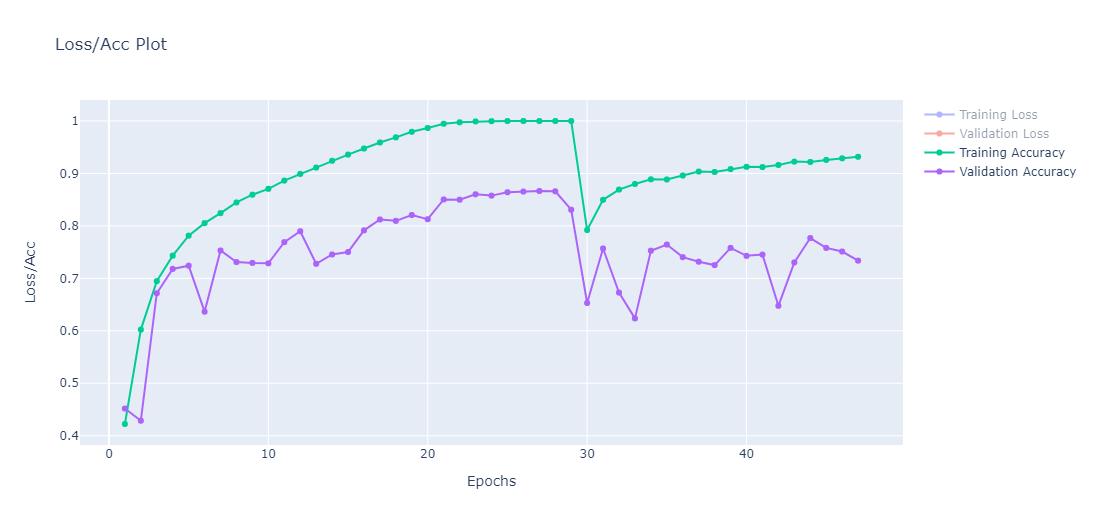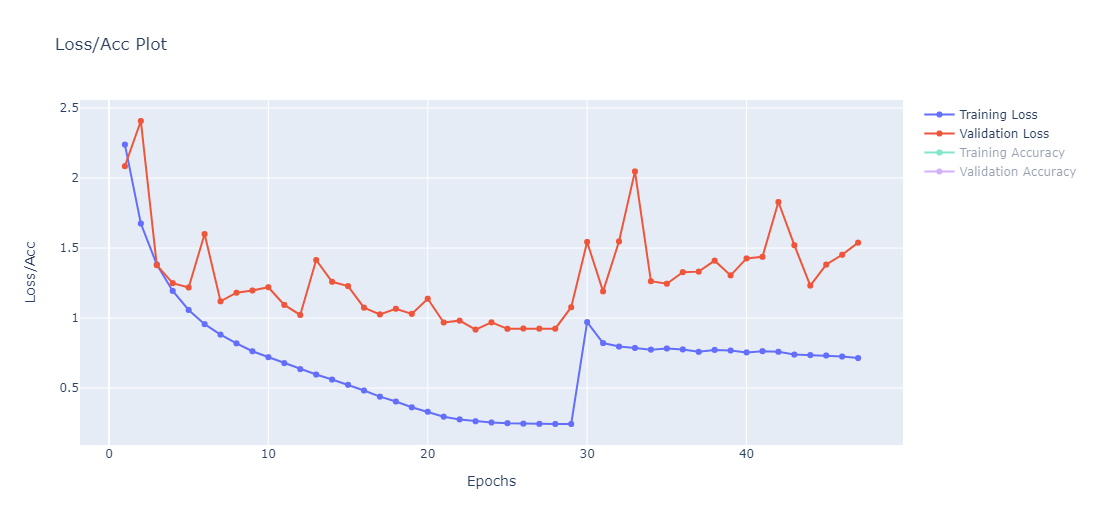

By observing the learning curve, we can see that this baseline CNN begins overfitting to our data. As such, our attention now turns towards reducing the variance of our data. 

In [ ]:
evaluator.add_remarks("Baseline_CNN_1", "Low Avoidable Bias but Overfits")

In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Baseline_MLP,0.631750,0.5247,0.107050,High Variance
1,Baseline_CNN_1,0.999825,0.8665,0.133325,Low Avoidable Bias but Overfits


In [ ]:
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/CIFAR10/history.csv


#### With Basic Data Augmentation

In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Baseline_MLP,0.631750,0.5247,0.107050,High Variance
1,Baseline_CNN_1,0.999825,0.8665,0.133325,Low Avoidable Bias but Overfits


In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
baseline_data_aug = build_baseline_cnn(optimizer, name="Baseline_CNN_1_DataAug")

Model: "Baseline_CNN_1_DataAug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 3)         7         
_________________________________________________________________
basic_conv_block (BasicConvB (None, 16, 16, 32)        10400     
_________________________________________________________________
basic_conv_block_1 (BasicCon (None, 8, 8, 64)          55936     
_________________________________________________________________
basic_conv_block_2 (BasicCon (None, 4, 4, 128)         370560    
_________________________________________________________________
basic_conv_block_3 (BasicCon (None, 2, 2, 256)         1478400   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)    

In [ ]:
train_ds, val_ds = set_up_data_aug()
results, fig = evaluator.evaluate_model(baseline_data_aug, training_data=train_ds, validation_data=val_ds)

Training Baseline_CNN_1_DataAug
Epoch 1/200
313/313 [==============================] - 7s 15ms/step - loss: 2.2975 - accuracy: 0.3930 - val_loss: 2.0437 - val_accuracy: 0.4737
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_CNN_1_DataAug/assets
Epoch 2/200
313/313 [==============================] - 5s 15ms/step - loss: 1.7573 - accuracy: 0.5741 - val_loss: 2.2887 - val_accuracy: 0.4701
Epoch 3/200
313/313 [==============================] - 5s 15ms/step - loss: 1.4587 - accuracy: 0.6651 - val_loss: 2.4402 - val_accuracy: 0.4929
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_CNN_1_DataAug/assets
Epoch 4/200
313/313 [==============================] - 5s 15ms/step - loss: 1.2598 - accuracy: 0.7246 - val_loss: 1.6876 - val_accuracy: 0.6288
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/Baseline_CNN_1_DataAug/assets
Epoch 5/200
313/313 [=====

In [ ]:
display(results)
fig.show()

Epochs                                                               62
Batch Size                                                          128
Model Name                                       Baseline_CNN_1_DataAug
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/CIFAR10/S...
Train Loss                                                     0.225433
Test Loss                                                      0.697799
Train Acc                                                      0.996625
Test Acc                                                         0.8826
[Train - Test] Acc                                             0.114025
dtype: object

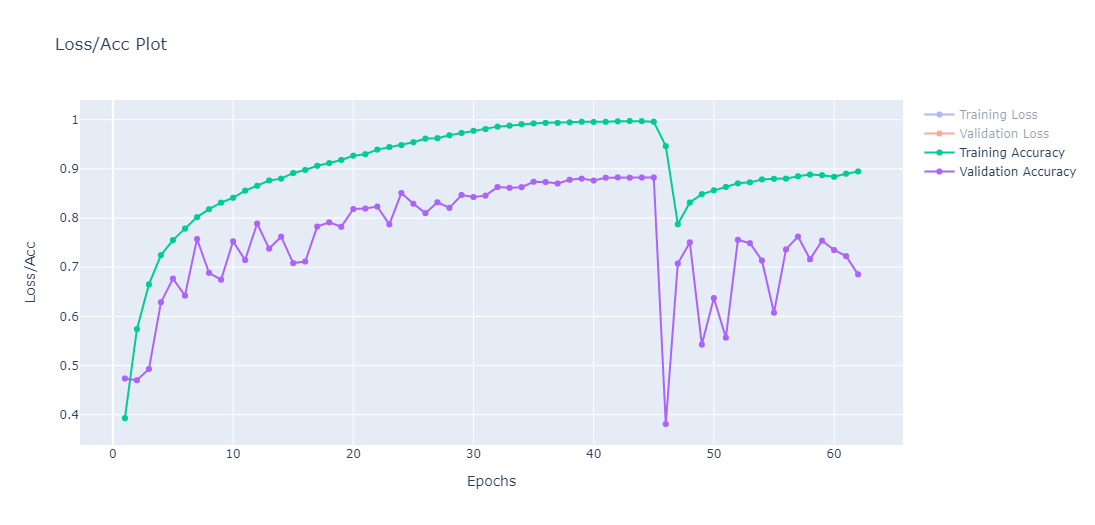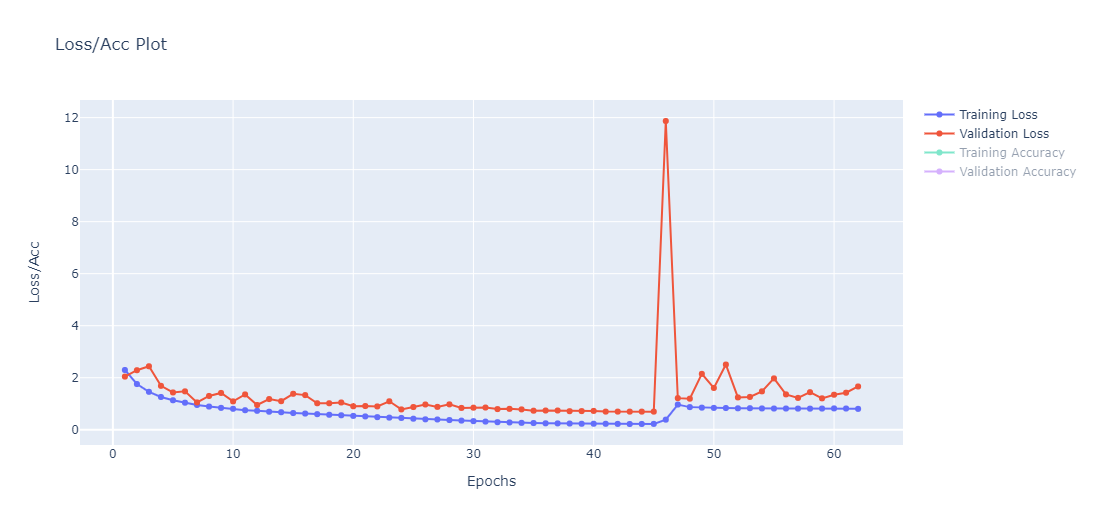

In [ ]:
evaluator.add_remarks("Baseline_CNN_1_DataAug", "Data Aug lowers variance, but still overfits")

In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Baseline_MLP,0.631750,0.5247,0.107050,High Variance
1,Baseline_CNN_1,0.999825,0.8665,0.133325,Low Avoidable Bias but Overfits
2,Baseline_CNN_1_DataAug,0.996625,0.8826,0.114025,"Data Aug lowers variance, but still overfits"


In [ ]:
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/CIFAR10/history.csv


### WideResNet
To improve upon our baseline, I make use of the [Wide ResNet](https://arxiv.org/abs/1605.07146v4) architecture. In summary, Wide ResNet is a Residual Network that goes for width instead of Depth. Although this would be expected to result in more overfitting, the overfitting can be counteracted by regularization, dropout and data augmentation. The benefits of going wide however are that:
- we can achieve higher validation accuracy
- faster training: it is easier to optimize the network


In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Baseline_MLP,0.631750,0.5247,0.107050,High Variance
1,Baseline_CNN_1,0.999825,0.8665,0.133325,Low Avoidable Bias but Overfits
2,Baseline_CNN_1_DataAug,0.996625,0.8826,0.114025,"Data Aug lowers variance, but still overfits"
3,efficientnetv2-s,0.320450,0.3495,-0.029050,


In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Baseline_MLP,0.631750,0.5247,0.107050,High Variance
1,Baseline_CNN_1,0.999825,0.8665,0.133325,Low Avoidable Bias but Overfits
2,Baseline_CNN_1_DataAug,0.996625,0.8826,0.114025,"Data Aug lowers variance, but still overfits"
3,efficientnetv2-s,0.320450,0.3495,-0.029050,NaN
7,ImprovedWideResNet_28_10_No_Stochastic_Depth_B...,0.997800,0.8739,0.123900,NaN
8,ImprovedWideResNet_28_10_No_Stochastic_Depth_B...,0.999425,0.9398,0.059625,NaN
9,ImprovedWideResNet_28_10_ProperDropout_No_Stoc...,0.998900,0.9456,0.053300,Best model thus far
10,ImprovedWideResNet_28_10_Dropout_No_Stochastic...,0.999850,0.9170,0.082850,NaN
11,WideResNet_28_10_Fixed_BasicDataAug,0.998625,0.9333,0.065325,NaN
12,WideResNet_28_10_Fixed_CutMix,0.916025,0.9391,-0.023075,NaN


In [93]:
# code adapted for Keras https://github.com/szagoruyko/wide-residual-networks/blob/master/models/wide-resnet.lua
class WideResNetLayer(Model):
  """
  B(3,3) block was found to perform the best
  Dropout is added between the convolutions, after activations
  Order of BN, Conv and ReLU changed to BN-Relu-Conv 
  """
  def __init__(self, num_channels, k, use_1x1conv=False, strides=1, activation='relu'):
    super(WideResNetLayer, self).__init__() # subclassing a layer
    self.activation = Activation(activation)
    self.bn_1 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform') # 
    self.conv_1 = Conv2D(num_channels * k, 3, strides=strides, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    self.dropout = Dropout(0.3) # 0.3 was found to be optimal for CIFAR-10
    self.bn_2 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
    self.conv_2 = Conv2D(num_channels * k, 3, strides=1, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    if use_1x1conv:
      self.conv3 = Conv2D(num_channels * k, 1, strides=strides,padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    else:
      self.conv3 = None
  def call(self, X):
    Y = self.bn_1(X)
    Y = self.activation(Y)
    Y = self.conv_1(Y)
    Y = self.bn_2(Y)
    Y = self.activation(Y)
    Y = self.dropout(Y)
    Y = self.conv_2(Y)
    if self.conv3 is not None: 
      X = self.conv3(X) # shortcut connection
    Y += X
    return Y

In [102]:
class WideResnetBlock(Layer):
    def __init__(self, num_channels, k, num_residuals, first_block=False, layer=WideResNetLayer, activation='relu', dropout=0.3,
                 **kwargs):
        super(WideResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if first_block:
                self.residual_layers.append(
                    layer(num_channels, k, use_1x1conv=True, strides=1, activation=activation, dropout=dropout))              
            elif i == 0:
                self.residual_layers.append(
                    layer(num_channels, k, use_1x1conv=True, strides=2, activation=activation, dropout=dropout))
            else:
                self.residual_layers.append(layer(num_channels, k, strides=1, activation=activation, dropout=dropout))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [96]:
def build_wideresnet(optimizer, loss='categorical_crossentropy',name = "WideResNet_28_10", layer=WideResNetLayer, activation='relu'):
  """
  WideResNet
  - Depth of 28
  - All filters multiplied by a factor of 10
  """
  k = 10
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs) # Normalization
  x = Conv2D(16, 3, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')(x)
  x = WideResnetBlock(16, k, 4, first_block=True, activation=activation, layer=layer)(x)
  x = WideResnetBlock(32, k, 4, activation=activation, layer=layer)(x)
  x = WideResnetBlock(64, k, 4, activation=activation, layer=layer)(x)
  x = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation(activation)(x)
  # Global Pooling
  x = GlobalAveragePooling2D()(x) 
  # Classification Head
  x = Dense(10, 'softmax', kernel_regularizer=l2(WEIGHT_DECAY), kernel_initializer='he_normal')(x)
  model = Model(inputs=inputs, outputs=x, name=name)
  model.compile(optimizer=optimizer,loss=loss, metrics=['accuracy'])
  print(model.summary())
  return model

#### Without Data Augmentation

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
callbacks = [
                        TerminateOnNaN(),
             CSVLogger("/tmp/training.log", append=False)
]
train_ds, val_ds = set_up_data_aug()

model = build_wideresnet(optimizer, name="WideResNet_28_10_Fixed_BasicDataAug")
results, fig = evaluator.evaluate_model(model, training_data=train_ds, validation_data=val_ds,callbacks=callbacks)
evaluator.save_history()


Model: "WideResNet_28_10_Fixed_BasicDataAug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 16)        432       
                                                                 
 wide_resnet_block_3 (WideRe  (None, 32, 32, 160)      1719744   
 snetBlock)                                                      
                                                                 
 wide_resnet_block_4 (WideRe  (None, 16, 16, 320)      6972800   
 snetBlock)                                                      
                               

In [ ]:
display(results)
fig.show()

Epochs                                                               60
Batch Size                                                          128
Model Name                          WideResNet_28_10_Fixed_BasicDataAug
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/CIFAR10/S...
Train Loss                                                     0.294071
Test Loss                                                      0.531471
Train Acc                                                      0.998625
Test Acc                                                         0.9333
[Train - Test] Acc                                             0.065325
dtype: object

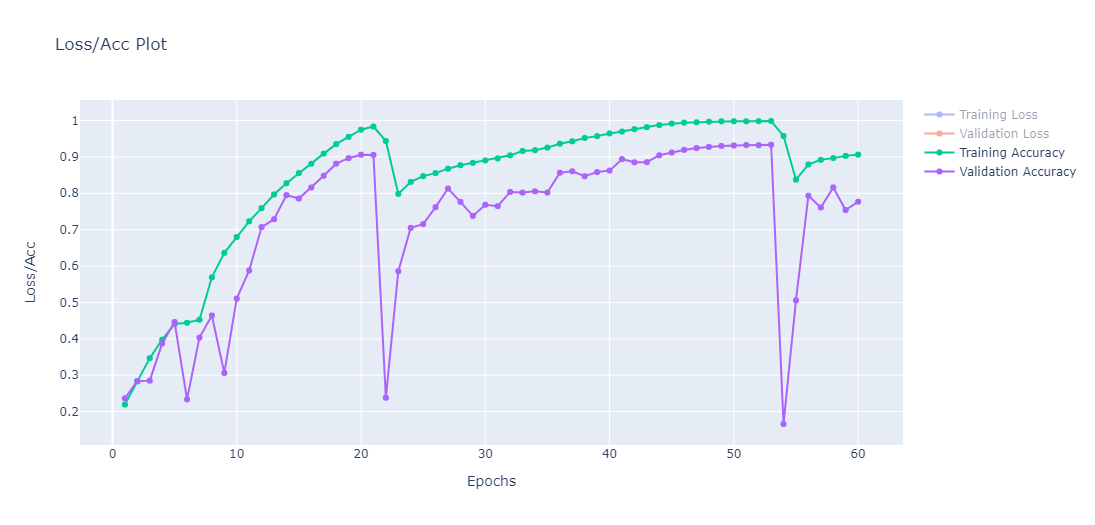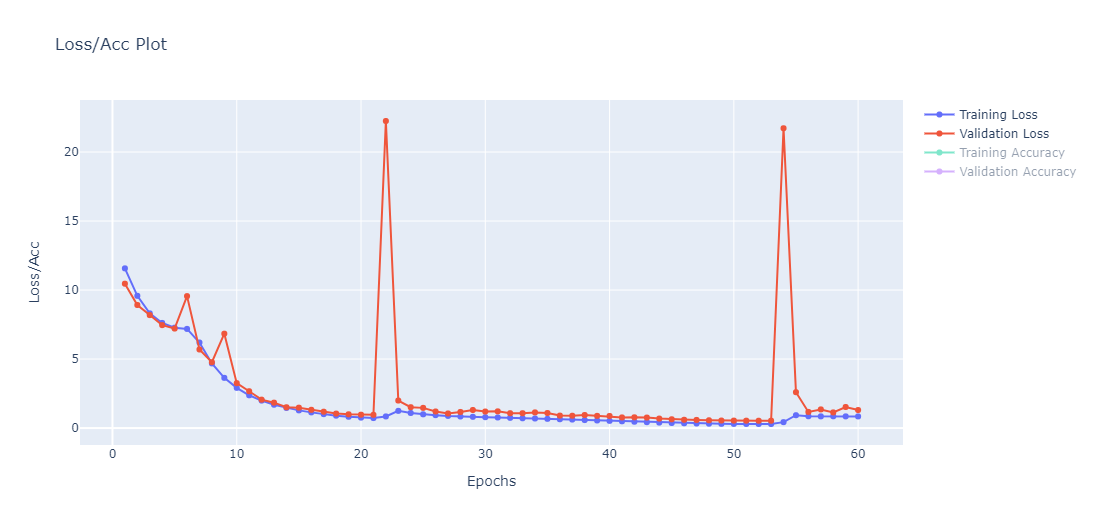

We can observe that Wide ResNet is able to train very well, reaching 93% validation accuracy in less than 60 epochs. However, we see that the model heavily overfits.

## Model Improvement

### CutMix
I observe that even with basic data augmentation, dropout and L2 regularization, the model still heavily overfits.

To counteract this overfitting, I employ a SOTA data augmentation method known as CutMix.

It works by cutting out portions of other images, and pasting them over another image. In additon, the label will be modified to reflect that the image contains two classes. This helps the model learn to identify an object from a partial view of it, improving generalization. 

Implementation adapted from: https://keras.io/examples/vision/cutmix/

In [97]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
  gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
  gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
  return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
  cut_rat = tf.math.sqrt(1.0 - lambda_value)
  image_wh = IMG_SIZE[0]
  cut_wh = image_wh * cut_rat  # rw
  cut_wh = tf.cast(cut_wh, tf.int32)

  cut_x = tf.random.uniform((1,), minval=0, maxval=image_wh, dtype=tf.int32)  # rx
  cut_y = tf.random.uniform((1,), minval=0, maxval=image_wh, dtype=tf.int32)  # ry

  boundaryx1 = tf.clip_by_value(cut_x[0] - cut_wh // 2, 0, image_wh)
  boundaryy1 = tf.clip_by_value(cut_y[0] - cut_wh // 2, 0, image_wh)
  bbx2 = tf.clip_by_value(cut_x[0] + cut_wh // 2, 0, image_wh)
  bby2 = tf.clip_by_value(cut_y[0] + cut_wh // 2, 0, image_wh)

  target_h = bby2 - boundaryy1
  if target_h == 0:
      target_h += 1

  target_w = bbx2 - boundaryx1
  if target_w == 0:
      target_w += 1

  return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
  (image1, label1), (image2, label2) = train_ds_one, train_ds_two
  image_size = IMG_SIZE[0]
  alpha = [1]
  beta = [1]

  # Get a sample from the Beta distribution
  lambda_value = sample_beta_distribution(1, alpha, beta)

  # Define Lambda
  lambda_value = lambda_value[0][0]

  # Get the bounding box offsets, heights and widths
  boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

  # Get a patch from the second image (`image2`)
  crop2 = tf.image.crop_to_bounding_box(
      image2, boundaryy1, boundaryx1, target_h, target_w
  )
  # Pad the `image2` patch (`crop2`) with the same offset
  image2 = tf.image.pad_to_bounding_box(
      crop2, boundaryy1, boundaryx1, image_size, image_size
  )
  # Get a patch from the first image (`image1`)
  crop1 = tf.image.crop_to_bounding_box(
      image1, boundaryy1, boundaryx1, target_h, target_w
  )
  # Pad the `image1` patch (`crop1`) with the same offset
  img1 = tf.image.pad_to_bounding_box(
      crop1, boundaryy1, boundaryx1, image_size, image_size
  )

  # Modify the first image by subtracting the patch from `image1`
  # (before applying the `image2` patch)
  image1 = image1 - img1
  # Add the modified `image1` and `image2`  together to get the CutMix image
  image = image1 + image2

  # Adjust Lambda in accordance to the pixel ration
  lambda_value = 1 - (target_w * target_h) / (image_size * image_size)
  lambda_value = tf.cast(lambda_value, tf.float32)

  # Combine the labels of both images
  label = lambda_value * label1 + (1 - lambda_value) * label2
  return image, label

In [98]:
def set_up_cutmix():
  train_ds_one = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048)
  train_ds_two =  tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048)
  val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two)) 
  train_ds_cutmix = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
  return train_ds_cutmix, val_ds


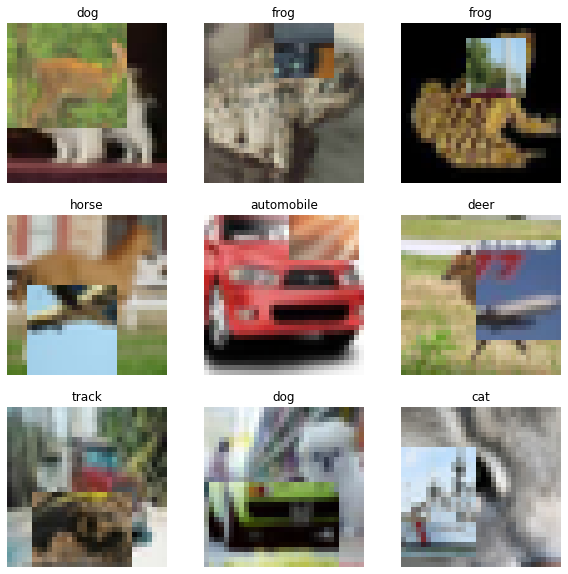

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()
image_batch, label_batch = next(iter(train_cutmix_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_labels[np.argmax(label_batch[i])])
    plt.imshow(tf.squeeze(image_batch[i]))
    plt.axis("off")

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()
model = build_wideresnet(optimizer, name="WideResNet_28_10_Fixed_CutMix")
results, fig = evaluator.evaluate_model(model, training_data=train_cutmix_ds, validation_data=val_ds,callbacks=callbacks)
evaluator.save_history()


Model: "WideResNet_28_10_Fixed_CutMix"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 16)        432       
                                                                 
 wide_resnet_block_3 (WideRe  (None, 32, 32, 160)      1719744   
 snetBlock)                                                      
                                                                 
 wide_resnet_block_4 (WideRe  (None, 16, 16, 320)      6972800   
 snetBlock)                                                      
                                     

We stop the training at 100 epochs since the model appears to stop improving.

In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Baseline_MLP,0.631750,0.5247,0.107050,High Variance
1,Baseline_CNN_1,0.999825,0.8665,0.133325,Low Avoidable Bias but Overfits
2,Baseline_CNN_1_DataAug,0.996625,0.8826,0.114025,"Data Aug lowers variance, but still overfits"
3,efficientnetv2-s,0.320450,0.3495,-0.029050,NaN
4,WideResNet_28_10_BasicDataAug,0.982225,0.9072,0.075025,NaN
5,ImprovedWideResNet_28_10,0.743250,0.7258,0.017450,NaN
6,ImprovedWideResNet_28_10_No_Stochastic_Depth,0.879075,0.7844,0.094675,NaN
7,ImprovedWideResNet_28_10_No_Stochastic_Depth_B...,0.997800,0.8739,0.123900,NaN
8,ImprovedWideResNet_28_10_No_Stochastic_Depth_B...,0.999425,0.9398,0.059625,NaN
9,ImprovedWideResNet_28_10_ProperDropout_No_Stoc...,0.998900,0.9456,0.053300,Best model thus far


Impressively, Cutmix seems to allow us to reach the same level of performance, while greatly reducing overfitting. 

### Squeeze and Excite Blocks
[Paper](https://arxiv.org/pdf/1709.01507.pdf)
- Introduces a new block, the Squeeze and Excitation block, that can be integrated into architectures like VGGNet, Inception Network and ResNet
- It is inserted after the non-linearlity following each convolution
- Main Idea: add parameters to each channel of a convolutional block that let's the network adjust the weighting of each feature map
- Normally, each channel is treated equally by the network when creating the output feature map
- The SE block **squeezes** the feature maps to a single vector of numbers, with the size being the number of feature maps. It is then fed into a fully connected layer network, outputting a vector of the same size (the excitation). The idea is that the dense layer can learn to value certain channels more, and that the vector represents a kind of weight vector for each channel.
- So it can be seen as a form of Channel Wise attention for the model
- I'm trying it out as it has been shown to improve the performance of CNN architectures on datasets like CIFAR-10

In [99]:
class SEBlock(Model):
  """
  Implementation of squeeze and excite block based on the original paper
  """
  def __init__(self, channels, reduction_ratio=16, activation='relu'):
    super(SEBlock, self).__init__()
    self.squeeze = GlobalAveragePooling2D()
    self.excite_1 = Dense(channels // reduction_ratio, activation=activation, kernel_initializer='he_normal', kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False)
    self.excite_2 = Dense(channels, activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False)
  def call(self, X):
    Y = self.squeeze(X)
    Y = self.excite_1(Y)
    Y = self.excite_2(Y) 
    return Multiply()([X, Y])

In [101]:
# code adapted for Keras https://github.com/szagoruyko/wide-residual-networks/blob/master/models/wide-resnet.lua
class SEWideResNetLayer(Model):
  """
  B(3,3) block was found to perform the best
  Dropout is added between the convolutions, after activations
  Order of BN, Conv and ReLU changed to BN-Relu-Conv 
  """
  def __init__(self, num_channels, k, use_1x1conv=False, strides=1, activation='relu', dropout=0.3):
    super(SEWideResNetLayer, self).__init__() # subclassing a layer
    self.activation = Activation(activation)
    self.bn_1 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform') # 
    self.conv_1 = Conv2D(num_channels * k, 3, strides=strides, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    self.dropout = Dropout(dropout) # 0.3 was found to be optimal for CIFAR-10
    self.bn_2 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
    self.conv_2 = Conv2D(num_channels * k, 3, strides=1, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    if use_1x1conv:
      self.conv3 = Conv2D(num_channels * k, 1, strides=strides,padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    else:
      self.conv3 = None
    self.se = SEBlock(num_channels * k, activation=activation)
  def call(self, X):
    Y = self.bn_1(X)
    Y = self.activation(Y)
    Y = self.conv_1(Y)
    Y = self.bn_2(Y)
    Y = self.activation(Y)
    Y = self.dropout(Y)
    Y = self.conv_2(Y)
    Y = self.se(Y)
    if self.conv3 is not None: 
      X = self.conv3(X) # shortcut connection
    Y += X
    return Y

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()
model = build_wideresnet(optimizer, name="SEWRN_28_10_Fixed_Cutmix", layer=SEWideResNetLayer)
results, fig = evaluator.evaluate_model(model, training_data=train_cutmix_ds, validation_data=val_ds,callbacks=callbacks)
evaluator.save_history()

Model: "SEWRN_28_10_Fixed_Cutmix"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        432       
                                                                 
 wide_resnet_block_1 (WideRe  (None, 32, 32, 160)      1732544   
 snetBlock)                                                      
                                                                 
 wide_resnet_block_2 (WideRe  (None, 16, 16, 320)      7024000   
 snetBlock)                                                      
                                          

In [ ]:
display(results)
fig.show()

Epochs                                                              200
Batch Size                                                          128
Model Name                                     SEWRN_28_10_Fixed_Cutmix
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/CIFAR10/S...
Train Loss                                                       0.9066
Test Loss                                                      0.505669
Train Acc                                                       0.92925
Test Acc                                                         0.9461
[Train - Test] Acc                                             -0.01685
dtype: object

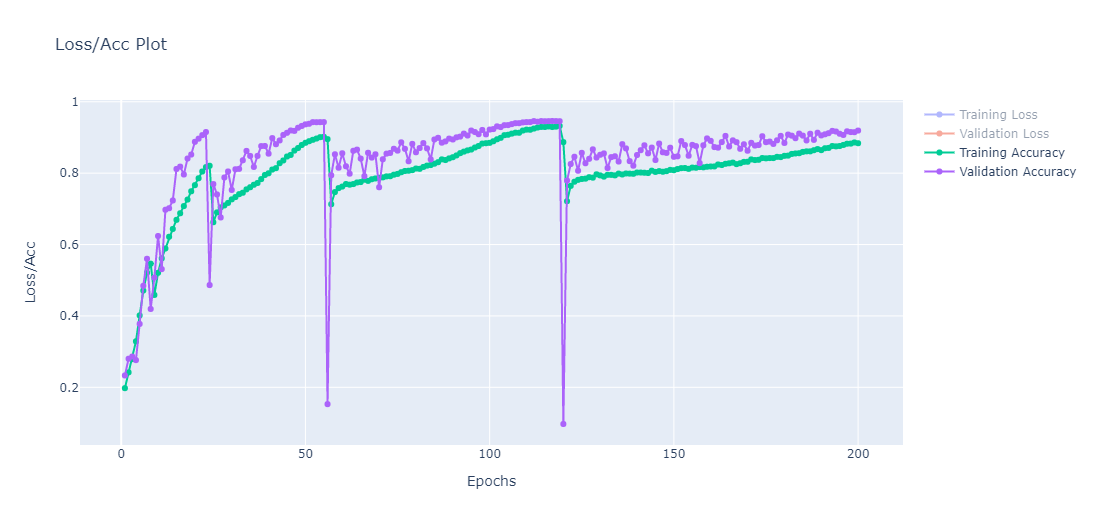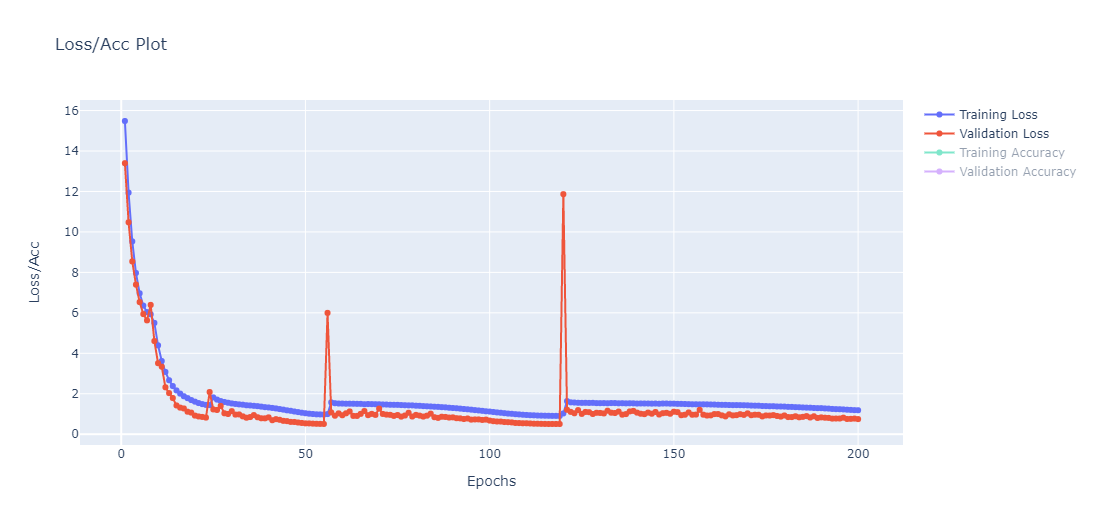

It can be seen that WRN with SE and Cutmix does very well, managing to avoid overfitting, while achieving a high validation accuracy of 94.6% 

### Mish Activation
As an additional improvement, I try changing the activation function with the Mish activation. The [Mish activation](https://arxiv.org/vc/arxiv/papers/1908/1908.08681v1.pdf) is a proposed activation function defined as
$$
f(z) = z * \tanh (softplus (z)) 
$$

It has been shown to provide improvements over ReLU over many benchmark datasets, at some cost the time taken for training

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()
model = build_wideresnet(optimizer, name="SEWRN_28_10_Fixed_Cutmix_Mish", layer=SEWideResNetLayer, activation=mish)
results, fig = evaluator.evaluate_model(model, training_data=train_cutmix_ds, validation_data=val_ds,callbacks=callbacks)
evaluator.save_history()

Model: "SEWRN_28_10_Fixed_Cutmix_Mish"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        432       
                                                                 
 wide_resnet_block (WideResn  (None, 32, 32, 160)      1732544   
 etBlock)                                                        
                                                                 
 wide_resnet_block_1 (WideRe  (None, 16, 16, 320)      7024000   
 snetBlock)                                                      
                                     

It seems that Mish activation does not help our model at all, so we stick to ReLU activation.

### Snapshot Emsembling of the Hypertuned Model
By following the procedure in [Snapshot Ensembles: Train 1, get M for free](https://arxiv.org/abs/1704.00109v1), I can make use of the model weights before each warm restart for an ensemble model. The logic is that the warm restart scheduling means that each model snapshot before the warm restart will be at a different local minima, and so by taking a snapshot, we can effectively ensemble many diverse models at no additional training cost.

Now normally in deployment, an ensemble deep learning model would not be used since it is computationally expensive during inference, but as an interesting exercise to see how much I can improve the model, I think it's worth a try.

To do this I will,
1. Load the model from the epochs before each warm restart. This is possible as the model has been saved at every epoch
2. Make a meta model, that just takes the average prediction of all the models


In [117]:
print("Final Learning Rate:", LR)

Final Learning Rate: 0.05


In [119]:
class Snapshot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs["val_accuracy"] > 0.9: # save those epochs with potential
      self.model.save(f"/content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/ensemble_{epoch}_{logs['val_accuracy']}")

In [124]:
callbacks = [
             Snapshot()
]

lr_scheduler = tf.keras.optimizers.schedules.CosineDecayRestarts(
    LR,
    steps_per_epoch * 10 # found to work well for CIFAR10 with shorter training time
)
optimizer = SGD(
    learning_rate = lr_scheduler,
    momentum = momentum
)

train_cutmix_ds, val_ds = set_up_cutmix()
model = build_wideresnet(optimizer, name="SEWRN_Cutmix_Ensemble", layer=SEWideResNetLayer)
results, fig = evaluator.evaluate_model(model, training_data=train_cutmix_ds, validation_data=val_ds,callbacks=callbacks)
evaluator.save_history()

Model: "SEWRN_Cutmix_Ensemble"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        432       
                                                                 
 wide_resnet_block (WideResn  (None, 32, 32, 160)      1732544   
 etBlock)                                                        
                                                                 
 wide_resnet_block_1 (WideRe  (None, 16, 16, 320)      7024000   
 snetBlock)                                                      
                                             

In [127]:
display(results)
fig.show()

Epochs                                                              156
Batch Size                                                          128
Model Name                                        SEWRN_Cutmix_Ensemble
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/CIFAR10/S...
Train Loss                                                     0.885244
Test Loss                                                       0.48893
Train Acc                                                      0.936875
Test Acc                                                         0.9458
[Train - Test] Acc                                          -0.00892502
dtype: object

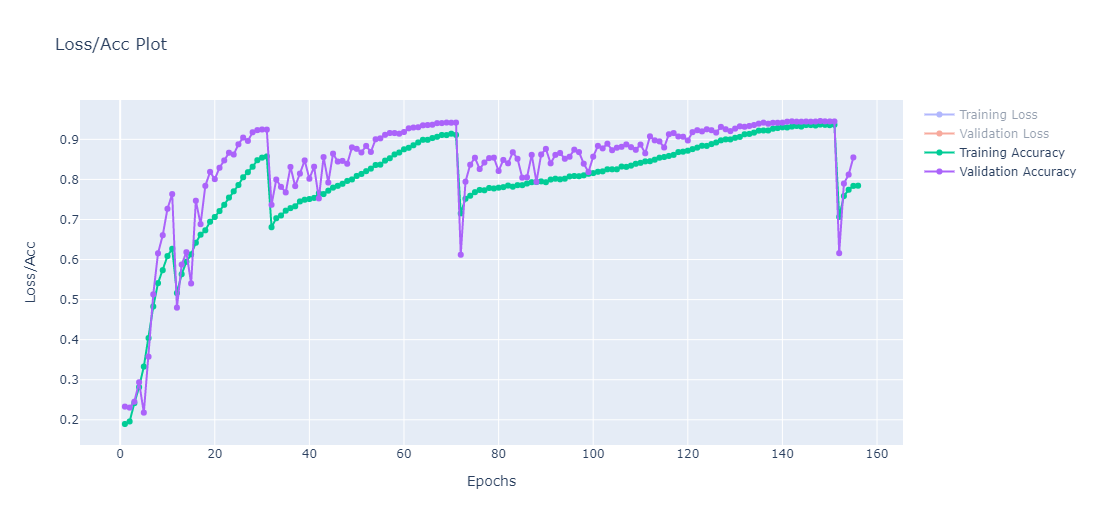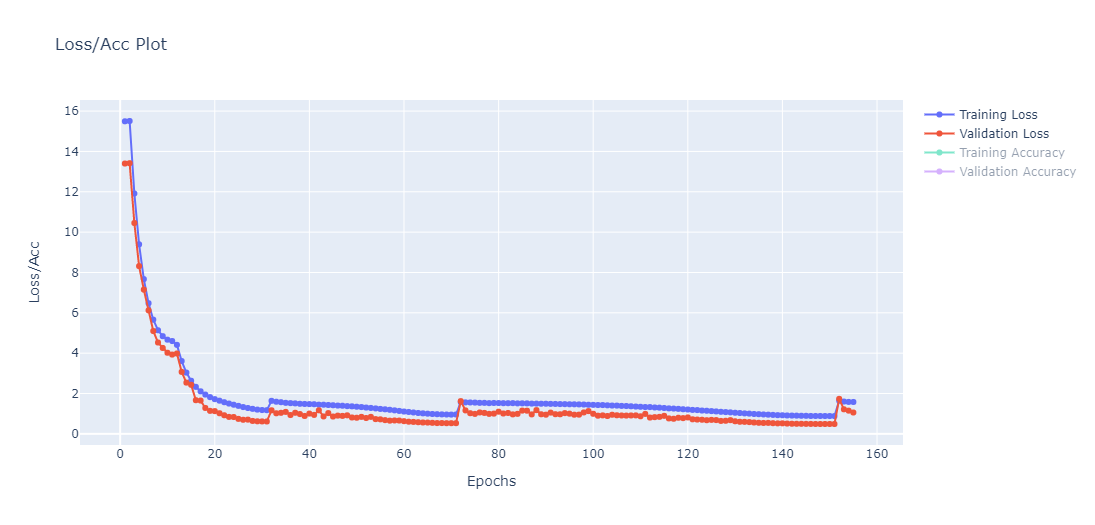

In [165]:
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/CIFAR10/history.csv


In [126]:
names = [
         "ensemble_146_0.9458000063896179",
         "ensemble_69_0.9417999982833862",
         "ensemble_29_0.9243000149726868"
]
models = [
          tf.keras.models.load_model(f"/content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/{name}/") for name in names
]

To ensemble our models, I pick three checkpoints which are from before each warm restart, and load them. Their predictions are averaged and used to make a final prediction.

In [149]:
def ensemble(models, X):
  predicted_ensemble = [
                        model.predict(X)for model in models
  ]
  return np.argmax(np.mean(predicted_ensemble, axis=0), axis=1)


In [150]:
ensemble_results = ensemble(models, X_val)

In [138]:
y_val_int = np.argmax(y_val, axis=1)

In [143]:
from sklearn.metrics import accuracy_score

In [151]:
accuracy_score(y_val_int, ensemble_results)

0.9502

We can see that ensembling the three models together results in a 95% validation accuracy. This does come at a cost to computation time during inference. However, given that we are not aiming for speed here, the improved validation accuracy helps us achieve our goal of having a more robust model.

# Evaluating the Final Model
The final model is as follows:
- Wide ResNet 28, with an width expansion factor of 10
  - Pre-activation structure
  - L2 Regularization
  - Dropout on Conv Blocks and Classification Head
  - Squeeze and Excite (Channel Attention)
- Snapshot Ensembling with Three Models
- Cutmix Data Augmentation
- Stochastic Gradient Descent 
  - Using Stochastic Weight Averaging
  - Cosine Learning Rate Scheduler with Warm Restarts

In [148]:
evaluator.return_history().sort_values("Test Acc")

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
12,SEWRN_28_10_SWA_Cutmix,0.196825,0.2231,-0.026275,NaN
3,efficientnetv2-s,0.320450,0.3495,-0.029050,NaN
0,Baseline_MLP,0.631750,0.5247,0.107050,High Variance
11,SEWRN_28_10_Fixed_Cutmix_Mish,0.639800,0.7739,-0.134100,NaN
1,Baseline_CNN_1,0.999825,0.8665,0.133325,Low Avoidable Bias but Overfits
4,ImprovedWideResNet_28_10_No_Stochastic_Depth_B...,0.997800,0.8739,0.123900,NaN
2,Baseline_CNN_1_DataAug,0.996625,0.8826,0.114025,"Data Aug lowers variance, but still overfits"
7,ImprovedWideResNet_28_10_Dropout_No_Stochastic...,0.999850,0.9170,0.082850,NaN
8,WideResNet_28_10_Fixed_BasicDataAug,0.998625,0.9333,0.065325,NaN
9,WideResNet_28_10_Fixed_CutMix,0.916025,0.9391,-0.023075,NaN


### Testing Set
To ensure the model generalizes well, I evaluate it on the testing set.

In [152]:
# final_model = load_model("/content/drive/MyDrive/Data/DELE CA1/CIFAR10/SavedModels/SEWRN_28_10_Fixed_Cutmix")
y_test_int = np.argmax(y_test, axis=1)
y_pred = ensemble(models, X_test)

In [153]:
# final_model.evaluate(X_test, y_test)
accuracy_score(y_test_int, y_pred)

0.946

As can be observed, the test set accuracy is very close to the validation set accuracy, so we can safely say that the model does not appear to be overfitting.

In [154]:
from sklearn.metrics import classification_report

In [155]:
report = classification_report(
    y_test_int, y_pred, target_names=class_labels.values()
)
print(report)

              precision    recall  f1-score   support

    airplane       0.96      0.95      0.95      1000
  automobile       0.97      0.98      0.97      1000
        bird       0.94      0.93      0.93      1000
         cat       0.88      0.89      0.88      1000
        deer       0.94      0.96      0.95      1000
         dog       0.91      0.90      0.90      1000
        frog       0.96      0.97      0.96      1000
       horse       0.98      0.96      0.97      1000
        ship       0.97      0.97      0.97      1000
       truck       0.97      0.96      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



From the classification report, we see that
- The model has the most difficulty dealing with cats and dogs, which may be due to their roughly similar appearance
- The model does well on vehicles like trucks, ships, cars etc

### Error Analysis
I try to gain a better understanding of the examples where the model does badly.

In [163]:
wrong_example_mask = y_test_int != y_pred
X_test_wrong = X_test[wrong_example_mask]
y_test_wrong = y_test_int[wrong_example_mask]
y_pred_wrong = y_pred[wrong_example_mask]

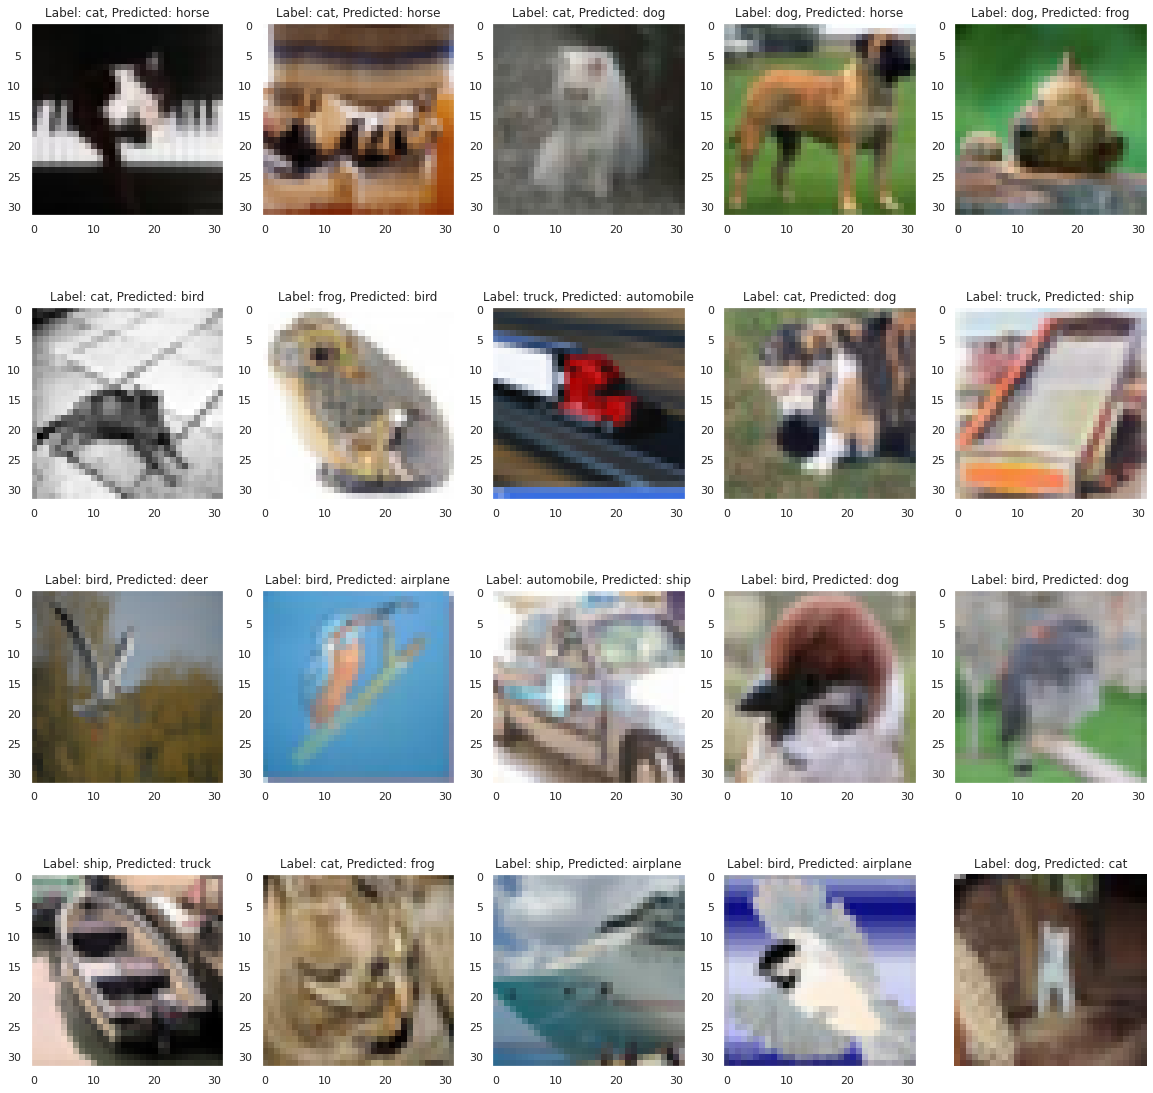

In [164]:
random_idxs = np.random.choice(X_test_wrong.shape[0], 20, replace=False)
fig, ax = plt.subplots(4, 5, figsize=(20, 20))
plt.axis("off")
for idx, subplot in zip(random_idxs, ax.ravel()):
  pred = class_labels[y_pred_wrong[idx]]
  actual = class_labels[y_test_wrong[idx]]
  subplot.imshow(X_test_wrong[idx], cmap='gray')
  subplot.set_title(f"Label: {actual}, Predicted: {pred}")

In some of these images (cat vs dog), the low resolution makes it unclear whether the picture contains a cat or dog as both have similar shapes. So this explains why the model doesn't do as well for cats and dogs. 

# Summary
- As can be observed, we have achieved our aim in creating a model for the CIFAR-10 dataset which does not overfit, and is able to generalize well to new data points
  - This can be seen by the small gap between the training and validation error, and the fact that the error on the independent test set is within 1% of the validation set error
  - This suggests that the model generally does well on new training examples, but can still make some mistakes.
  - We achieve this by using Cutmix Data Augmentation, L2 Regularization, Dropout, Squeeze and Excite Blocks, Snapshot Ensembling and Batch Normalization on a WRN-28-10 model.
- Nevertheless, there is room for improvement:
  - In the original WRN paper, they attained a < 4% error on CIFAR-10 (I have approx 6% error), but I have been unable to replicate this in Tensorflow 
    - It might just be differences between Tensorflow and PyTorch (the original paper was implemented in PyTorch), as other Tensorflow implementations of WRN also seemed to have difficulty matching the original results
  - I previously attempted to employ improved training methodology like using Stochastic Weight Averaging, but was unable to get it to work
  - Similarly, I attempted using Mish activation (I suspect it needs a lower learning rate to succeed) and Stochastic Depth but could not get the network to work well

